In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matplotlib import gridspec
from scipy.optimize import curve_fit

%matplotlib inline

In [6]:
class initialCleanUp:
    """ Cleaning up of the raw oscilliscope data. """
    def __init__(self, dataset):
        self.dataset = dataset
    
    def removeColsAndRows(self, dataStartRow):

        """
        Remove columns and rows that aren't useful for
        plotting.
        DataStartRow is the row where the data starts in the file.
        """

        self.dataset.drop(self.dataset.columns[[2]], axis=1, inplace=True)


        self.dataset = self.dataset.drop(labels=range(0, dataStartRow), axis=0)

        return self.dataset
    
class findPeaks:
    """ Finding the peaks of a panda dataset. """
    def __init__(self, data):
        self.data = data
    
    def max(self):
        """ 
        Find the maximum values and all of its corresponding row values.
        The twenty is so the values are off the exact peak by a little,
        it was suggested this would be a good step.
        """
        max_index = self.data.y.argmax()
        y_position_max = self.data.iloc[max_index+40, 0:2]
        return y_position_max
    
    def min(self):
        """ 
        Find the minimum values and all of its corresponding row values.
        The twenty is so the values are off the exact peak by a little,
        it was suggested this would be a good step.
        """
        min_index = self.data.y.argmin()
        y_position_min = self.data.iloc[min_index-40, 0:2]
        return y_position_min

# Plotting the raw data from oscilloscope

Text(0.5, 1.0, 'Plotting of the raw data.')

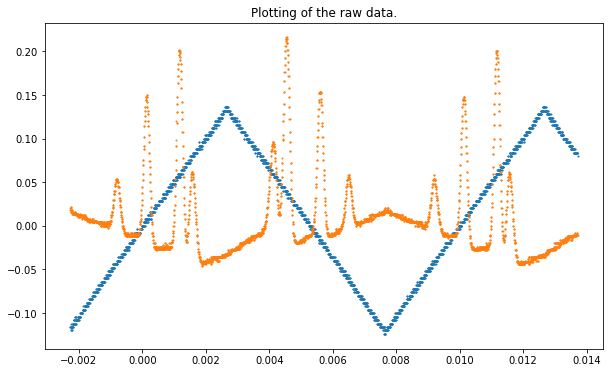

In [5]:
# Get the raw data from the oscilloscopes output
rawDopplerBroadenedData = pd.read_csv('/Users/starman/Desktop/PycharmProjects-fall-2021/'
                      'phy445-Lab1-FINAL/Data/dopplerBroadened--zoomOut/'
                      'A0000CH1.CSV')

rawTriangleWaveData = pd.read_csv('/Users/starman/Desktop/PycharmProjects-fall-2021/'
                      'phy445-Lab1-FINAL/Data/dopplerBroadened--zoomOut/'
                      'A0000CH2.CSV')

rawCopiedDopplerBroadenedData = rawDopplerBroadenedData.copy()
rawCopiedTriangleWaveData = rawTriangleWaveData.copy()


dataStart = 17

# Clear the unnessecary rows and columns from the raw data
cleanedUpDopplerBroadenedData = initialCleanUp(rawCopiedDopplerBroadenedData).removeColsAndRows(dataStart)
cleanedUpDopplerBroadenedData.columns = ['x', 'y']
cleanedUpDopplerBroadenedData = cleanedUpDopplerBroadenedData.astype(float)


cleanedUpTriangleWaveData = initialCleanUp(rawCopiedTriangleWaveData).removeColsAndRows(dataStart)
cleanedUpTriangleWaveData.columns = ['x', 'y']
cleanedUpTriangleWaveData = cleanedUpTriangleWaveData.astype(float)

# For the plots in this file
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])


ax1.scatter(cleanedUpTriangleWaveData['x'], cleanedUpTriangleWaveData['y'], s=1)
ax1.scatter(cleanedUpDopplerBroadenedData['x'], cleanedUpDopplerBroadenedData['y'], s=1)

plt.title('Plotting of the raw data.')

# Finding the peaks of the triangle wave

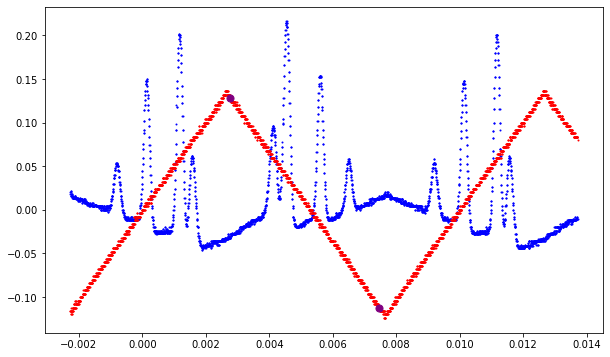

In [8]:
y_max_position = findPeaks(cleanedUpTriangleWaveData).max()
y_min_position = findPeaks(cleanedUpTriangleWaveData).min()

# For the plots in this file
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.scatter(cleanedUpDopplerBroadenedData['x'], cleanedUpDopplerBroadenedData['y'], c='blue', s=1)
ax1.scatter(cleanedUpTriangleWaveData['x'], cleanedUpTriangleWaveData['y'], c='red', s=1)

ax1.scatter(y_min_position[0], y_min_position[1], s=50, c='purple')
ax1.scatter(y_max_position[0], y_max_position[1], s=50, c='purple')

# Chopping off the ends of the data

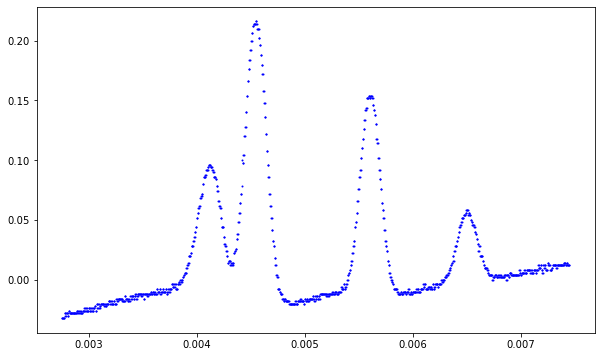

In [10]:
choppedOffDopplerData = cleanedUpDopplerBroadenedData.loc[(cleanedUpDopplerBroadenedData.x >= y_max_position[0]) &
                                                      (cleanedUpDopplerBroadenedData.x <= y_min_position[0])]


# For the plots in this file
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.scatter(choppedOffDopplerData['x'], choppedOffDopplerData['y'], s=1, c='blue')

# Fitting this data with a linear line and 4 Gaussians

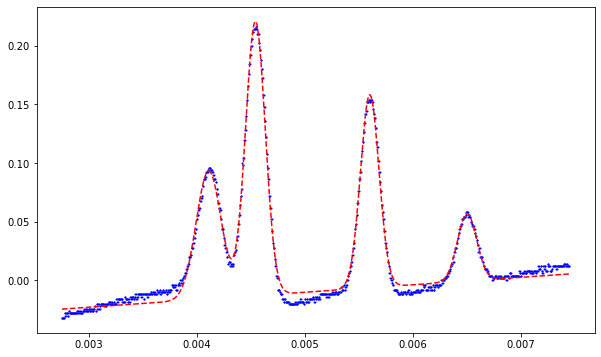

In [16]:
def fourGaussianAndLine(x,a,b, amp1,cen1,sigma1, amp2,cen2,sigma2, amp3,cen3,sigma3, amp4,cen4,sigma4):
    return ( a*x +b + (amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2.0))) +
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2.0))) +
            amp3*(1/(sigma3*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2.0))) +
            amp4*(1/(sigma4*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2.0)))))

guess = [1,-0.01, 0.01,0.0042,1e-5, 0.01,0.0046,1e-5, 0.01,0.0055,1e-5, 0.01,0.0065,1e-5]


fitParameters, covParameters = curve_fit(f = fourGaussianAndLine,
                                        xdata = choppedOffDopplerData['x'],
                                        ydata = choppedOffDopplerData['y'],
                                        p0 = guess)

a, b = fitParameters[0], fitParameters[1]
ampl1, cent1, sigm1 = fitParameters[2], fitParameters[3], fitParameters[4]
ampl2, cent2, sigm2 = fitParameters[5], fitParameters[6], fitParameters[7]
ampl3, cent3, sigm3 = fitParameters[8], fitParameters[9], fitParameters[10]
ampl4, cent4, sigm4 = fitParameters[11], fitParameters[12], fitParameters[13]

outputFitValues = [fourGaussianAndLine(i, a, b,
                                ampl1,cent1,sigm1, 
                               ampl2, cent2, sigm2, 
                               ampl3, cent3, sigm3,
                               ampl4, cent4, sigm4) for i in choppedOffDopplerData['x']]

# For the plots in this file
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.scatter(choppedOffDopplerData['x'], choppedOffDopplerData['y'], s=1, c='blue')
ax1.plot(choppedOffDopplerData['x'], outputFitValues, '--', c='red')

# Estimating the error using technique shown in lab

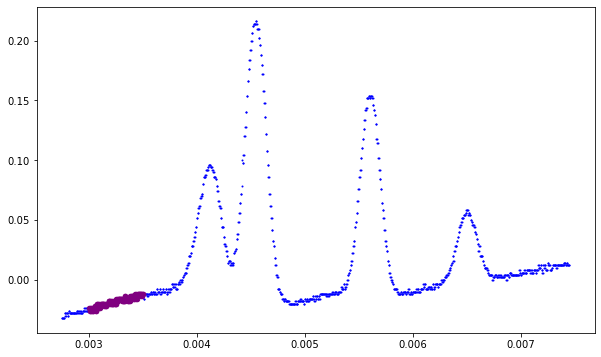

In [33]:
# Picking out a linear segment


linearSegment = choppedOffDopplerData.loc[(choppedOffDopplerData.x >= 0.003) &
                                          (choppedOffDopplerData.x <= 0.0035)]



# For the plots in this file
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.scatter(choppedOffDopplerData['x'], choppedOffDopplerData['y'], s=1, c='blue')
ax1.scatter(linearSegment['x'], linearSegment['y'], s=20, c='purple')



# Fitting the linear segment with a straight line

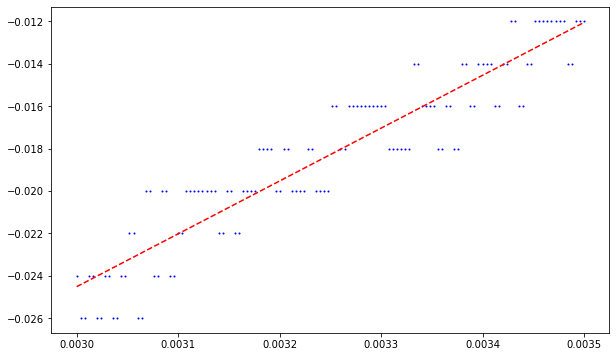

In [35]:


# For the plots in this file
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

def linear(x, a, b):
    return a*x+b

guess = [1, -0.02]

fitParameters1, fitCov1 = curve_fit(f=linear,
                                   xdata = linearSegment['x'],
                                   ydata = linearSegment['y'],
                                   p0 = guess)

a = fitParameters1[0]
b = fitParameters1[1]

fitCurveValues = pd.DataFrame(linearSegment['x'])
fitCurveValues['y'] = [linear(i, a, b) for i in linearSegment['x']]

ax1.scatter(linearSegment['x'], linearSegment['y'], s=1, c='blue')
ax1.plot(linearSegment['x'], fitCurveValues['y'], '--', c='red')

# Calculating the difference between data and best fit line

In [42]:
# Merging the two data sets for easier difference calculation
result = pd.merge(linearSegment, fitCurveValues, on=['x'])
result.columns = ['x', 'y_segmentRawData','y_bestFit']


# Calculating the difference between the raw data and the best fit y values,then squaring each of those columns
result['diff_y'] = result['y_segmentRawData'] - result['y_bestFit']
result['diff_y_squared'] = result['diff_y']**2.0
print(result)
sumOfDiffSquared = result['diff_y_squared'].sum()
numberOfRows = result['diff_y_squared'].count()

# Degrees of freedoms = numberofdatapoints - fitParameters - 1
sigmaY = np.sqrt(sumOfDiffSquared/(numberOfRows-2-1))
print('sigma y value:', sigmaY)

            x  y_segmentRawData  y_bestFit    diff_y  diff_y_squared
0    0.003000            -0.024  -0.024523  0.000523    2.731992e-07
1    0.003004            -0.026  -0.024423 -0.001577    2.487266e-06
2    0.003008            -0.026  -0.024323 -0.001677    2.811988e-06
3    0.003012            -0.024  -0.024223  0.000223    4.986738e-08
4    0.003016            -0.024  -0.024124  0.000124    1.525683e-08
..        ...               ...        ...       ...             ...
121  0.003484            -0.014  -0.012448 -0.001552    2.408983e-06
122  0.003488            -0.014  -0.012348 -0.001652    2.728712e-06
123  0.003492            -0.012  -0.012248  0.000248    6.166629e-08
124  0.003496            -0.012  -0.012149  0.000149    2.206278e-08
125  0.003500            -0.012  -0.012049  0.000049    2.375971e-09

[126 rows x 5 columns]
sigma y value: 0.0014699760554568975


# Calculating the chi squared value for this distribution

In [56]:
result1 = pd.DataFrame(choppedOffDopplerData['x'])
result1['y'] = [fourGaussianAndLine(i, a, b,
                                ampl1,cent1,sigm1, 
                               ampl2, cent2, sigm2, 
                               ampl3, cent3, sigm3,
                               ampl4, cent4, sigm4) for i in choppedOffDopplerData['x']]

wholeCurveValues = pd.merge(choppedOffDopplerData, result1, on=['x'])
wholeCurveValues.columns = ['x', 'y_rawData', 'y_bestFit']

# Calculating the difference between raw data and best fit; then squaring that result
wholeCurveValues['diff_y'] = wholeCurveValues['y_rawData'] - wholeCurveValues['y_bestFit']
wholeCurveValues['diff_y_squared'] = wholeCurveValues['diff_y']**2.0


# Dividing the differences squared by the sigma calculated in the previous box
wholeCurveValues['diff_y_squared_div_bySigma'] = wholeCurveValues['diff_y_squared']/(sigmaY**2.0)

print(wholeCurveValues)

# Calculating the value involved in the chi-square reduced tabulation
sumOfColumn = wholeCurveValues['diff_y_squared_div_bySigma'].sum()
numberOfRows = wholeCurveValues['diff_y_squared_div_bySigma'].count()

numberOfFitParameters = 14
degreesOfFreedom = numberOfRows - numberOfFitParameters - 1

chiSquareReduced = sumOfColumn / degreesOfFreedom

print('Chi-squared reduced value for this best-fit:', chiSquareReduced)


             x  y_rawData  y_bestFit    diff_y  diff_y_squared  \
0     0.002748     -0.032  -0.030810 -0.001190        0.000001   
1     0.002752     -0.032  -0.030710 -0.001290        0.000002   
2     0.002756     -0.032  -0.030610 -0.001390        0.000002   
3     0.002760     -0.032  -0.030510 -0.001490        0.000002   
4     0.002764     -0.032  -0.030410 -0.001590        0.000003   
...        ...        ...        ...       ...             ...   
1170  0.007428      0.012   0.085947 -0.073947        0.005468   
1171  0.007432      0.012   0.086046 -0.074046        0.005483   
1172  0.007436      0.012   0.086146 -0.074146        0.005498   
1173  0.007440      0.012   0.086246 -0.074246        0.005512   
1174  0.007444      0.012   0.086346 -0.074346        0.005527   

      diff_y_squared_div_bySigma  
0                       0.655845  
1                       0.770408  
2                       0.894189  
3                       1.027187  
4                       1.169401

# Converting the distance between the centers to GHz using conversion factor calculated on the fabry-perot plot

In [57]:
print(cent1, cent2, cent3, cent4)

0.004106140597359963 0.004538813681392526 0.005597477940968758 0.006498110034892545


In [62]:
#conversion factor computed from the fabry-perot plot
conversionFactor = 0.00036774954107929666

separation1 = (cent2 - cent1) / conversionFactor
separation2 = (cent3 - cent2) / conversionFactor
separation3 = (cent4 - cent3) / conversionFactor
print('separation1:', separation1)
print('separation2:', separation2)
print('separation3:', separation3)
print('sum:', separation1+separation2+separation3)

separation1: 1.1765428252139323
separation2: 2.8787643254949855
separation3: 2.4490366222634847
sum: 6.504343772972403


# Sigma anaylsis

In [66]:
FWHM_s_sigma1 = sigm1 * 2.355
FWHM_s_sigma2 = sigm2 * 2.355
FWHM_s_sigma3 = sigm3 * 2.355
FWHM_s_sigma4 = sigm4 * 2.355

FWHM_ghz_sigma1 = FWHM_s_sigma1 / conversionFactor
FWHM_ghz_sigma2 = FWHM_s_sigma2 / conversionFactor
FWHM_ghz_sigma3 = FWHM_s_sigma3 / conversionFactor
FWHM_ghz_sigma4 = FWHM_s_sigma4 / conversionFactor

print('curve 1(MHz):', FWHM_ghz_sigma1*1000)
print('curve 2(MHz):', FWHM_ghz_sigma2*1000)
print('curve 3(MHz):', FWHM_ghz_sigma3*1000)
print('curve 4(MHz):', FWHM_ghz_sigma4*1000)

curve 1(MHz): 742.0302993369179
curve 2(MHz): 584.0374883822086
curve 3(MHz): 549.0377216775461
curve 4(MHz): 566.4769628766292
